## Data exploration
We resume working on the dataset by exploring more deeply the data in the clean timeseries.

Some analysis that we will be doing:
* Univariate distributions
* Feature engineering
* Missingness
* Independent imputation (Wind Speed)
* Correlation
* Outlier detection
* Conditioned imputation (Active power)

In [1]:
# Data loading
import os
import logging
import time
import sys

import pandas as pd

os.chdir(os.path.dirname(sys.path[0]))

def safe_open_w(path):
    ''' Open "path" for writing, creating any parent directories as needed.
    '''
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return open(path, 'w+')

log_file_name = 'run_logs/data_exploration.log'
safe_open_w(log_file_name).close()  # create empty logfile
logging.basicConfig(
    filename=log_file_name,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%d-%m-%Y %H:%M:%S',
    )

START_TIME = time.time()

def get_td(current_time=None):
    if not current_time:
        current_time = time.time()
    return '{:.1f} s'.format(current_time-START_TIME)

logging.info(f"Start data analysis - {get_td()}")
wind_df = pd.read_csv(
    "wind/data/example_clean.csv",
    index_col=0,
    low_memory=False,
    )

logging.info(f"Clean dataset loaded - {get_td()}")
wind_df.head()

,datetime,Datum (Anlage),Zeit (Anlage),Ereignis,Wind Speed (avg),Rotor Speed [rpm] (avg),Active Power (avg),Nacelle Position (avg),Generator Speed [rpm] (avg),Feature 0,...,Feature 55,Feature 56,Feature 57,Feature 58,Feature 59,Feature 60,Feature 61,Feature 62,Feature 63,Feature 82
0,2015-01-01 00:00:00,2015-01-01,00:00:00,NaN,3.08,0.0,-10.0,244.0,13.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:10:00,2015-01-01,00:10:00,NaN,3.43,0.0,-5.0,240.0,14.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 00:20:00,2015-01-01,00:20:00,NaN,3.53,0.0,-8.0,239.0,16.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 00:30:00,2015-01-01,00:30:00,NaN,3.58,0.0,-7.0,253.0,20.35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 00:40:00,2015-01-01,00:40:00,NaN,3.69,0.0,-7.0,260.0,21.69,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ereignis
Leistungsbetrieb (10m)             4327
keine Leistung trotz Wind (10m)     190
Name: count, dtype: int64


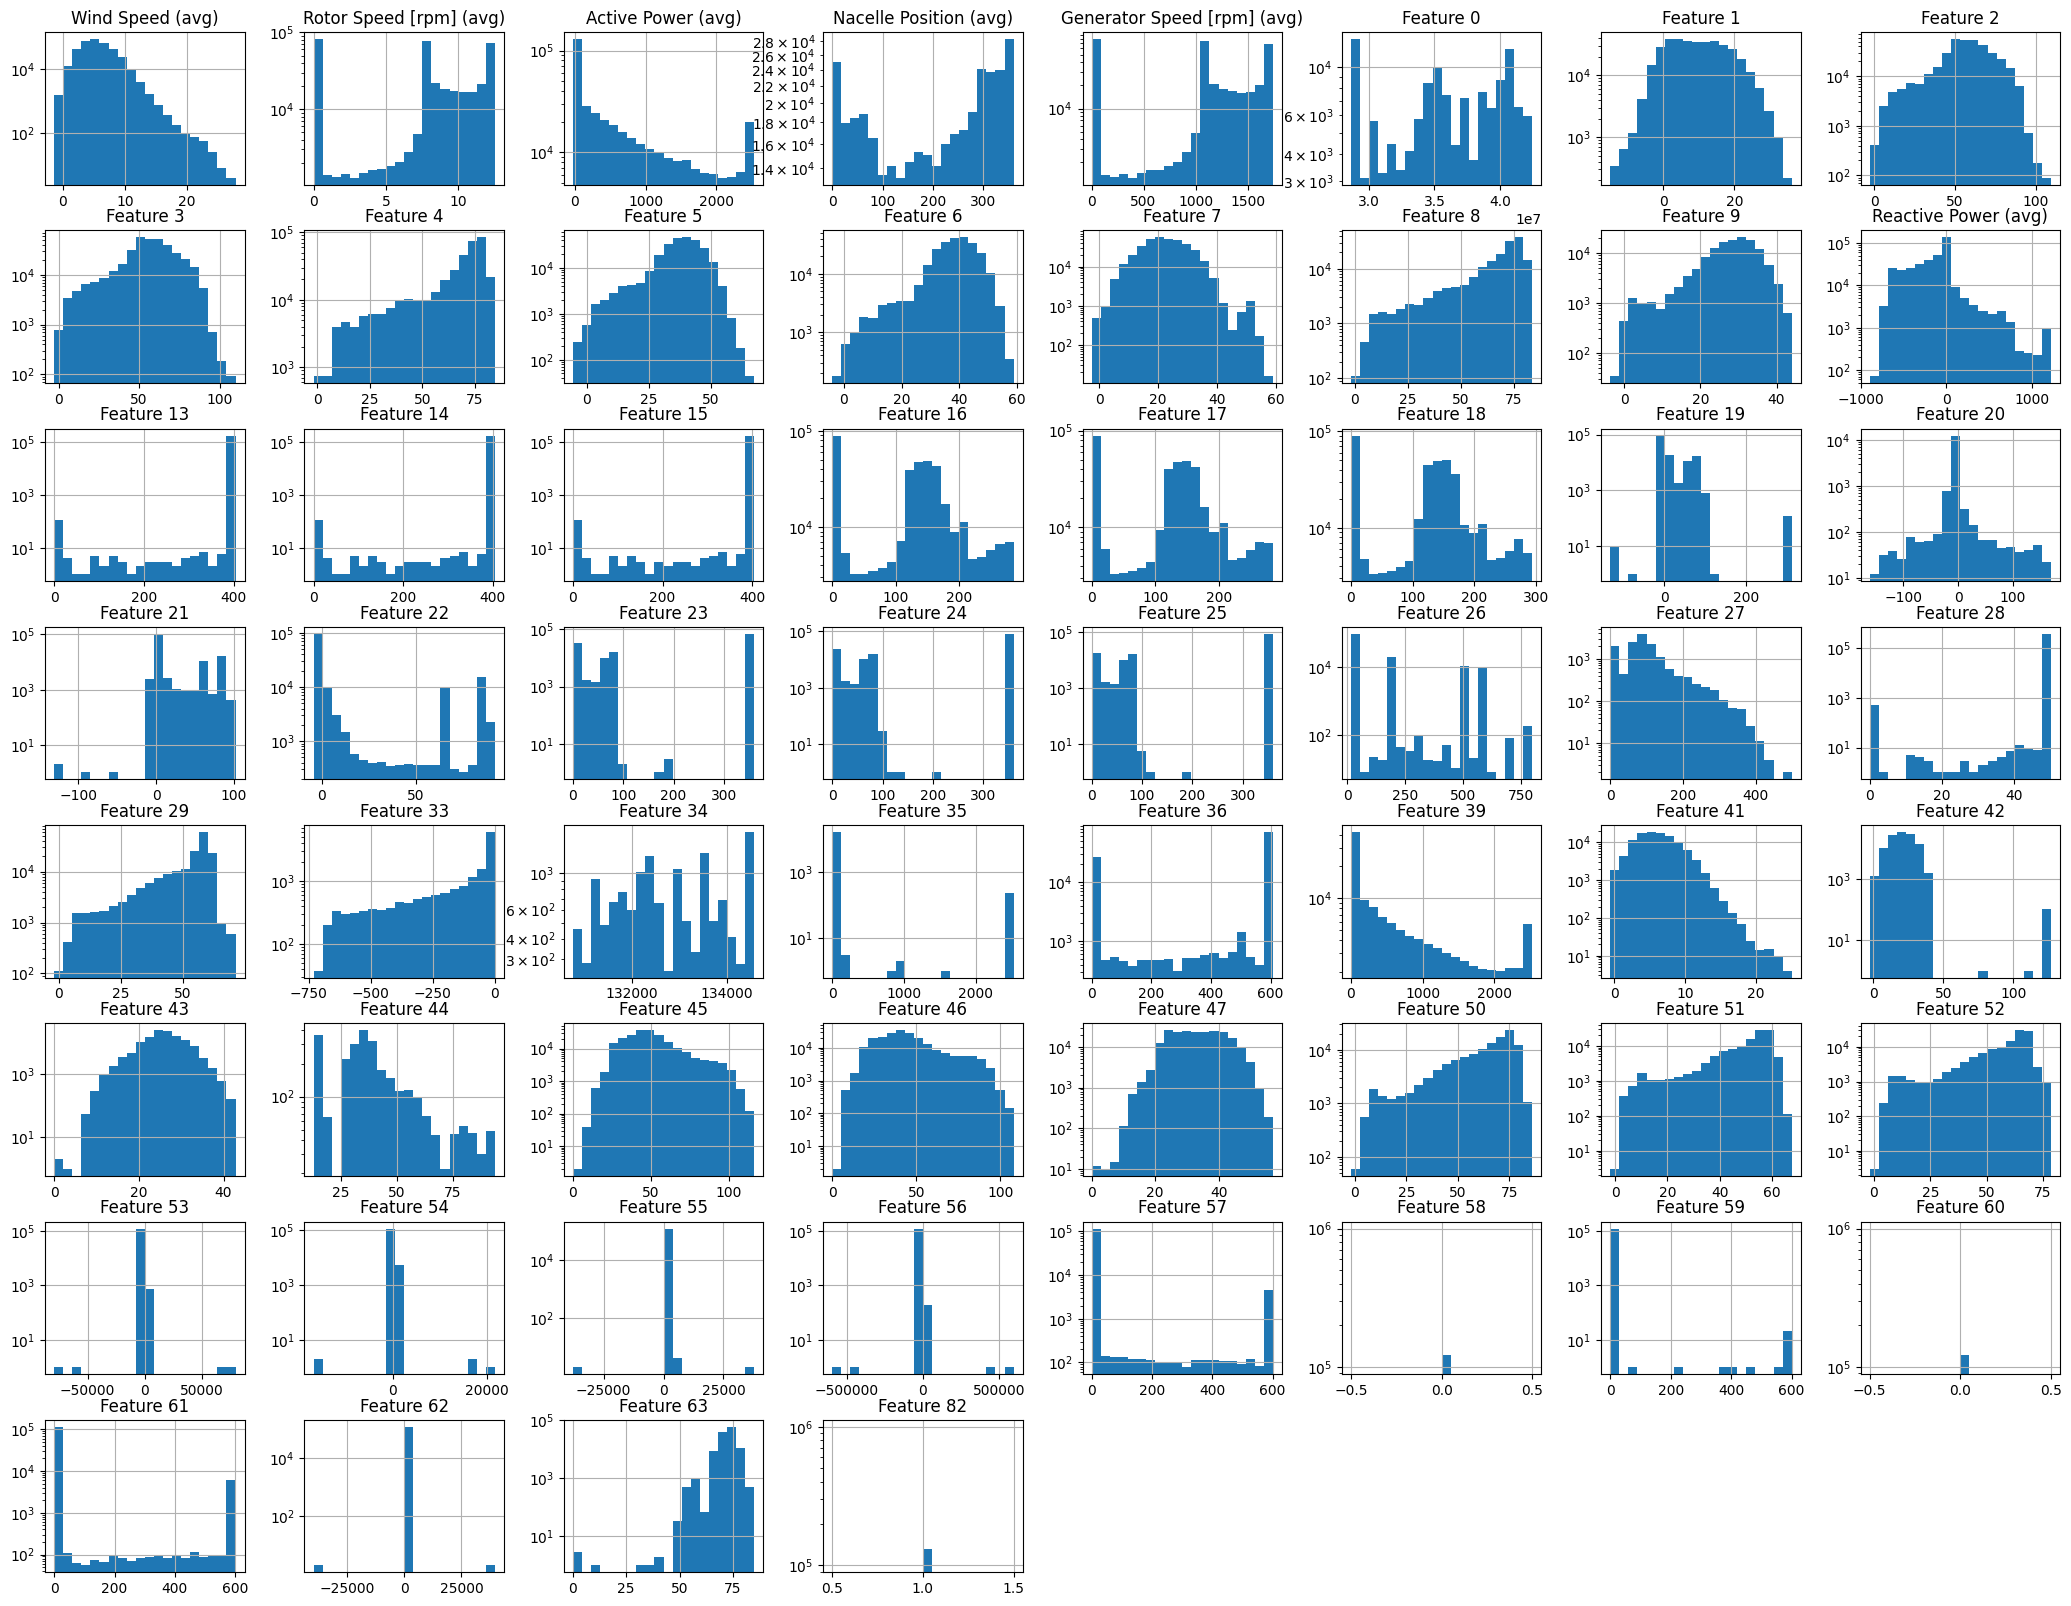

In [2]:
# Univariate data distributions
import matplotlib.pyplot as plt

print(wind_df['Ereignis'].value_counts())

wind_df.hist(bins=20, figsize=(26,20), log=True)
plt.show()

Based on the knowledge that we have from the previous notebook and these histograms, we observe:
* Nacelle position is an angle measurement, which could be encoded as a polar variable
* Datetime is a timeline, which could be encoded as a polar variable for time of the year and time of day
* Ereignis, or Event, column can be encoded as a categorical variable, it has a few observations flagged as 'Leistungsbetrieb (10m)' (Power operation (10m)?) and 'keine Leistung trotz Wind (10m)' (No power output despite wind (10m)?)
* Features [58, 60, 82] are possibly mask features, could be encoded the same as Ereignis column
* Features [19, 21, 23, 24, 25, 35, 42, 43, 53, 54, 55, 56, 59, 62] seem to have multiple modes and are very sparse, these could be discretized and then encode each detected mode

Additionally [Wind speed, rotor speed, generator speed, active power, reactive power, nacelle position (polar encoded)] have probably a very strong temporal dynamic that can be valuable to capture, we could investigate and extract temporal features from these.

We will create a sklearn transformer that adds encoded features to add to our dataset (we will not apply pre-processing to categorical columns at this stage, just feature engineering).

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

column_types = {
    "angle": ['Nacelle Position (avg)'],
    "datetime": ['datetime'],
    "categorical": [
        'Ereignis',
        'Feature 58',
        'Feature 60',
        'Feature 82',
    ],
    "multimodal": [
        'Feature 19',
        'Feature 21',
        'Feature 23',
        'Feature 24',
        'Feature 25',
        'Feature 35',
        'Feature 42',
        'Feature 43',
        'Feature 53',
        'Feature 54',
        'Feature 55',
        'Feature 56',
        'Feature 59',
        'Feature 62',
    ],
    "timeseries": [
        'Wind Speed (avg)',
        'Rotor Speed [rpm] (avg)',
        'Generator Speed [rpm] (avg)',
        'Active Power (avg)',
        'Reactive Power (avg)',
    ],
}


class PolarTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period:float|None=None, unit:str|None='degree', cosine:bool=True, sine:bool=True):
        """Converts a cyclic variable to polar coordinates based in a period and period unit."""
        time_periods = ['day', 'hour', 'minute', 'second']
        if unit == 'degree':
            self.unit = unit
            self.period = self.period_value = 360
        elif unit in time_periods:
            self.unit = unit
            self.period = period if period else 1
            self.period_value = pd.Timedelta(self.period, self.unit).value
        else:
            raise ValueError(f"Valid period units for this transformer are 'degree' for  angle variables or {time_periods} for time/date variables")
    
        self.cosine = cosine
        self.sine = sine
        
        self.column_name = None
        self.output_col_names = None
        self.is_fit = False
    
    def fit(self, X:pd.Series, y=None):
        self.column_name = X.name
        self.output_col_names = [f"{self.column_name}_{self.period}_{self.unit[0]}_{f}" for f, use in zip(["cos", "sin"], [self.cosine, self.sine]) if use]
        self.is_fit = True
        return self
    
    def transform(self, X:pd.Series) -> pd.DataFrame:
        if not self.is_fit:
            raise ValueError("Transformer has not been fit.")
        if X.dtype not in ['int64', 'float64']:
            X = X.astype('datetime64[ns]').astype('int64')
        X = (X/self.period_value).values
        data = np.array([f(X*(2*np.pi)) for f, use in zip([np.cos, np.sin], [self.cosine, self.sine]) if use]).T
        return pd.DataFrame(data, columns=self.output_col_names)

random_state=42

class MultimodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_modes:int=3, min_repr:float=.025, n_init:int=5):
        self.max_modes = max_modes
        self.min_repr = min_repr
        self.n_init = n_init
        self.kmeans = None
        self.encoder = None

        self.column_name = None
        self.output_col_names = None
        self.is_fit = False
    
    def fit(self, X:pd.Series, y=None):
        self.output_col_names = []
        self.column_name = X.name
        self.encoder = OneHotEncoder(sparse_output=False)
        X = X.dropna().values.reshape(-1, 1)
        smallest_distance = np.inf
        for i in range(2, self.max_modes+1):
            kmeans = KMeans(i, n_init=self.n_init, random_state=random_state).fit(X)
            c = kmeans.cluster_centers_
            _l = kmeans.labels_
            _, counts = np.unique(_l, return_counts=True)
            if min(counts/counts.sum()) < self.min_repr:  # Dont accept more modes if the least represented mode is below representation threshold
                break
            distances = np.array([np.abs(x - c[_l[i]]) for i, x in enumerate(X)])
            if (median_dist:=np.median(distances)) < smallest_distance:
                l = _l
                smallest_distance = median_dist
                self.kmeans = kmeans
        if self.kmeans:
            self.encoder.fit(l.reshape(-1, 1))
            self.output_col_names = [f"{self.column_name}_mode_{i}" for i in self.encoder.categories_[0]]
        self.is_fit = True
        return self
    
    def transform(self, X:pd.Series) -> pd.DataFrame:
        if not self.is_fit:
            raise ValueError("Transformer has not been fit.")
        if not self.kmeans:  # Significant modes not detected in fit, don't return features
            return pd.DataFrame(index=X.index)
        modes = pd.DataFrame(np.nan, index=X.index, columns=self.output_col_names)
        modes[~X.isna()] = self.encoder.transform(self.kmeans.predict(X[~X.isna()].values.reshape(-1, 1)).reshape(-1,1))
        return modes

class MixedTypesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_types: dict):
        self.column_types = column_types
        self.col_transformers = None

        self.column_names = None
        self.output_col_names = None
        self.is_fit = False
    
    def fit(self, X:pd.DataFrame, y=None):
        self.column_names = list(X.columns)
        self.col_transformers = []
        self.output_col_names = {}
        for col_type, cols in self.column_types.items():
            for col in cols:
                if col_type == "angle":
                    transformer = PolarTransformer(unit='degree')
                    transformer.fit(X[col])
                    self.col_transformers.append((col, col_type, transformer))
                elif col_type == "datetime":
                    transformer_timeofday = PolarTransformer(unit='day')
                    transformer_timeofyear = PolarTransformer(period=365, unit='day')
                    transformer_timeofday.fit(X[col])
                    transformer_timeofyear.fit(X[col])
                    self.col_transformers.append((col, col_type, transformer_timeofday))
                    self.col_transformers.append((col, col_type, transformer_timeofyear))
                if col_type == "multimodal":
                    transformer = MultimodeTransformer()
                    transformer.fit(X[col])
                    self.col_transformers.append((col, col_type, transformer))
        for _, col_type, transformer in self.col_transformers:
            self.output_col_names[col_type] = sum([self.output_col_names.get(col_type, []), transformer.output_col_names], [])
        self.is_fit = True
        return self
    
    def transform(self, X:pd.DataFrame) -> pd.DataFrame:
        if not self.is_fit:
            raise ValueError("Transformer has not been fit.")
        transformed_data = [X]
        for col, _, transformer in self.col_transformers:
            transformed_data.append(transformer.transform(X[col]))
        return pd.concat(transformed_data, axis=1)
    
new_feature_encoder = MixedTypesEncoder(column_types=column_types)
wind_df = new_feature_encoder.fit_transform(wind_df)
logging.info(f"Engineered features added - {get_td()}")

The following missing data events were detected:
             week_day  downtime_hours
2015-03-29    Sunday               1
2016-03-27    Sunday               1
2016-12-31  Saturday              24
2017-03-26    Sunday               1
2017-12-31    Sunday              24
2018-03-25    Sunday               1
2018-12-31    Monday              24
2019-03-31    Sunday               1
2019-12-31   Tuesday              24
2020-03-29    Sunday               1
2021-03-28    Sunday               1


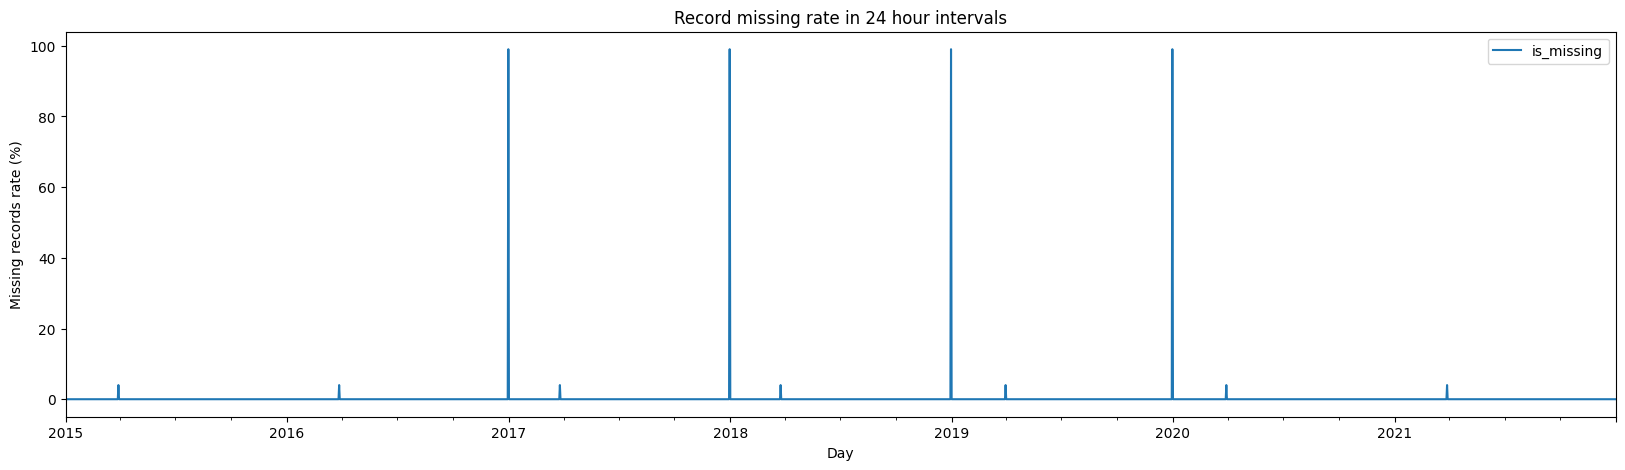

In [4]:
# Check datetime (vertical) missingness
sample_freq=pd.Timedelta(10, 'minutes')
time_ranges = pd.DataFrame(index=pd.date_range(start=wind_df.datetime.iloc[0], end=wind_df.datetime.iloc[-1], freq=sample_freq))
time_ranges['is_missing'] = False
time_ranges['is_missing'].loc[~time_ranges.index.isin(wind_df.datetime.values)] = True

bin_size = 24 # in days
bin_timedelta = pd.Timedelta(f"{bin_size}h").value
group_f = lambda x: pd.to_datetime((x.value//bin_timedelta)*bin_timedelta)
groups = time_ranges.groupby(time_ranges.index.to_series().apply(group_f))
bin_miss_rate = groups.mean()*100

ax = bin_miss_rate.astype(int).plot(figsize=(20,5), title=f'Record missing rate in {bin_size} hour intervals')
ax.set_xlabel('Day')
ax.set_ylabel('Missing records rate (%)')
ax.get_figure()

flag_pct_threshold = 1  # Missing rate percentage above this value is flagged as an event
events = pd.DataFrame.copy(bin_miss_rate.loc[bin_miss_rate.values>flag_pct_threshold], deep=True)
events['week_day'] = list(map(lambda x: x.strftime('%A'), events.index))
events['downtime_hours'] = (events['is_missing']/100*24).round().astype(int)
print("The following missing data events were detected:\n", events[['week_day', 'downtime_hours']])
logging.info(f"datetime missingness checked - {get_td()}")

There seems to be a regular 1 hour down time in the last Sunday of every March. This is probably scheduled maintenance.

There is a full day down time in the last day of the years 2016 to 2020.

Total missingness: 47.52%


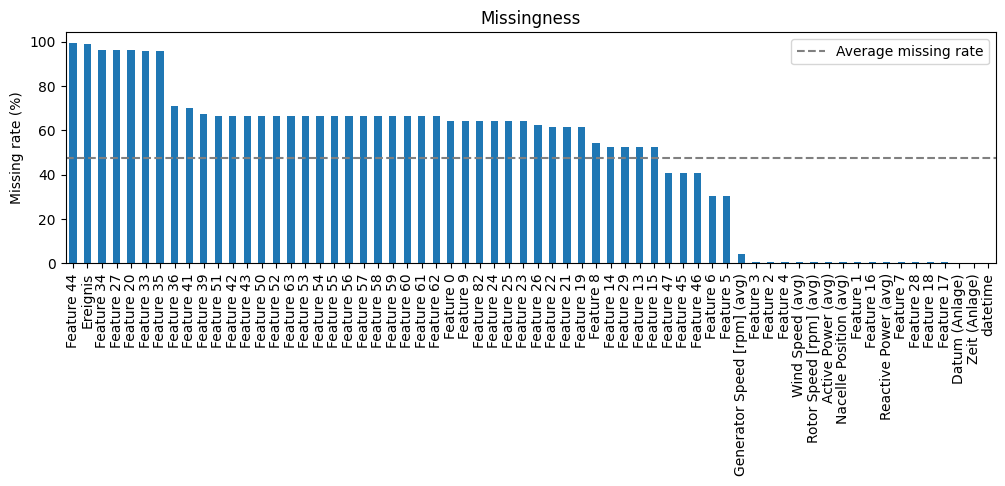

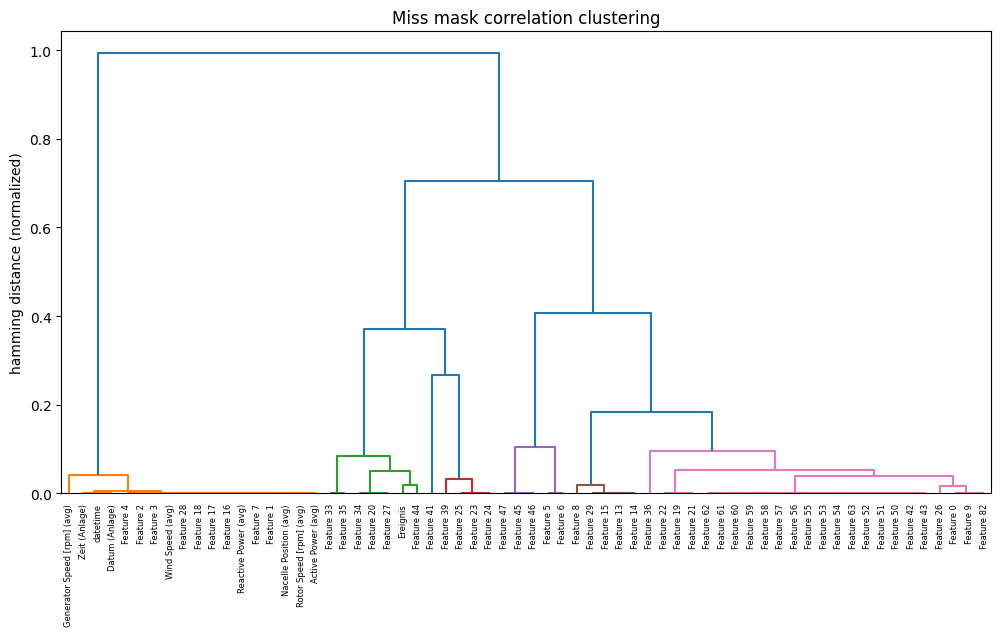

In [5]:
# Check feature level missingness
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

miss_mask = wind_df.isna()
missingness = 100*(miss_mask.sum()/wind_df.shape[0])
mean_missingness = missingness[new_feature_encoder.column_names].mean()
print(f"Total missingness: {mean_missingness:.2f}%")
plt.figure(figsize=(12, 3))
plt.title(f'Missingness')
plt.ylabel(f'Missing rate (%)')
plt.axhline(mean_missingness, color='gray', linestyle='dashed', label='Average missing rate')
missingness[new_feature_encoder.column_names].sort_values(ascending=False).plot(kind='bar')
plt.legend()

distance_metric = 'hamming'  # Normalized Hamming distance
distance_mat = pdist(miss_mask[new_feature_encoder.column_names].T, metric=distance_metric)  # Condensed distances (N)*(N-1)/2 array
#distance_mat = squareform(distance_mat)
linkage_mat = linkage(distance_mat, method='complete')
plt.figure(figsize=(12, 6))
correlation_thr = .15  # Increase to have bigger clusters
dend = dendrogram(linkage_mat, labels=list(miss_mask[new_feature_encoder.column_names].columns), color_threshold=correlation_thr)
plt.title(f'Miss mask correlation clustering')
plt.ylabel(f'{distance_metric} distance (normalized)')
plt.show()

clustered_cols = [(col, cluster) for col, cluster in zip([miss_mask.columns[i] for i in dend['leaves']], dend['leaves_color_list'])]
clusters = {cluster:[i[0] for i in clustered_cols if i[1]==cluster] for cluster in set(dend['leaves_color_list'])}
logging.info(f"Feature wise missingness checked - {get_td()}")

There is a high level of feature-level missingness in the dataset (47.52%) and a big variation in these values.

By using the normalized Hamming distance on the missingness mask we can correlate all features identify missingness patterns. This distance metric will attend to the total missingness and also the location of this missingness.

The dendrogram joins a cluster *a* with its counterpair *b* at a level *y*, where *y = dist(a, b)*. Basically it tells us which data tends to be collected together.
Variables like *datetime*, *Datum* and *Zeit* were alligned together in the data cleaning step, this leads to a 0 distance in the Hamming distances which also means they are joined at the same level.

Likely features that share a cluster will not be helpfull in building an imputing model since they are likely to be missing together, lets check the case for wind speed.

In [6]:
len(miss_mask[miss_mask['Wind Speed (avg)']]) - miss_mask[miss_mask['Wind Speed (avg)']].sum().sort_values()

datetime              1799
Datum (Anlage)        1799
Zeit (Anlage)         1799
datetime_365_d_cos    1799
datetime_1_d_sin      1799
                      ... 
Feature 44               0
Wind Speed (avg)         0
Ereignis                 0
Feature 27               0
Feature 33               0
Length: 94, dtype: int64

In this case only datetime variables are significantly present when wind speed is not registered. We can extract temporal features from the timeseries in order to build an imputation model for both the datetime missingness and the other missing records (within feature).

Since wind speed is not a static timeseries (there is seasonality in daily, yearly and other time scales) we will explore with Continuous Wavelet Transform which should help us capture the dynamics.

In [7]:
import phik

print(missingness[missingness<25].index)

correlation_feats = ['Generator Speed [rpm] (avg)', 'Feature 2', 'Feature 3', 'Feature 4',
       'Wind Speed (avg)', 'Reactive Power (avg)', 'Feature 1',
       'Active Power (avg)', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 28',
       'Rotor Speed [rpm] (avg)', 'Nacelle Position (avg)_360_d_cos',
       'Nacelle Position (avg)_360_d_sin', 'Feature 17',
       'datetime_1_d_cos', 'datetime_1_d_sin',
       'datetime_365_d_sin', 'datetime_365_d_cos']  # Removed the non-transformed versions of datetime and nacelle position

corr_mat = phik.phik_matrix(wind_df[correlation_feats])

def get_cor_feats(feat, corr_mat, thr=0.7):
    return list(corr_mat[feat][(corr_mat[feat]>0.8) & (corr_mat.index != feat)].index)

Index(['datetime', 'Datum (Anlage)', 'Zeit (Anlage)', 'Wind Speed (avg)',
       'Rotor Speed [rpm] (avg)', 'Active Power (avg)',
       'Nacelle Position (avg)', 'Generator Speed [rpm] (avg)', 'Feature 1',
       'Feature 2', 'Feature 3', 'Feature 4', 'Feature 7',
       'Reactive Power (avg)', 'Feature 16', 'Feature 17', 'Feature 18',
       'Feature 28', 'Nacelle Position (avg)_360_d_cos',
       'Nacelle Position (avg)_360_d_sin', 'datetime_1_d_cos',
       'datetime_1_d_sin', 'datetime_365_d_cos', 'datetime_365_d_sin'],
      dtype='object')
interval columns not set, guessing: ['Generator Speed [rpm] (avg)', 'Feature 2', 'Feature 3', 'Feature 4', 'Wind Speed (avg)', 'Reactive Power (avg)', 'Feature 1', 'Active Power (avg)', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 28', 'Rotor Speed [rpm] (avg)', 'Nacelle Position (avg)_360_d_cos', 'Nacelle Position (avg)_360_d_sin', 'Feature 17', 'datetime_1_d_cos', 'datetime_1_d_sin', 'datetime_365_d_sin', 'datetime_365_d_cos']


In [8]:
wind_df['datetime'] = wind_df.datetime.astype('datetime64[ns]')
full_series = wind_df[correlation_feats + ['datetime']].merge(time_ranges, how='right', right_index=True, left_on='datetime')
full_series['hour'] = full_series.datetime.apply(lambda x: (x.year, x.month, x.day, x.hour))
full_series.reset_index(drop=True, inplace=True)

# Gross imputation
miss_mask = full_series.isna()  # Keep mask to replace with finer imputation
full_series = full_series.fillna(method='ffill')  # Fill with previous value to perform CWT

resample_rate = pd.Timedelta(1,'h')  # Simplify CWT and create wider scales with smaller feature space
hour_groups = full_series.groupby('hour').filter(lambda g: g.hour.count()==resample_rate/sample_freq).groupby('hour')  # Incomplete groups in the edges filtered 
resampled_feats = hour_groups.mean().drop(columns=['datetime', 'is_missing'])
resampled_datetimes = hour_groups['datetime'].first()

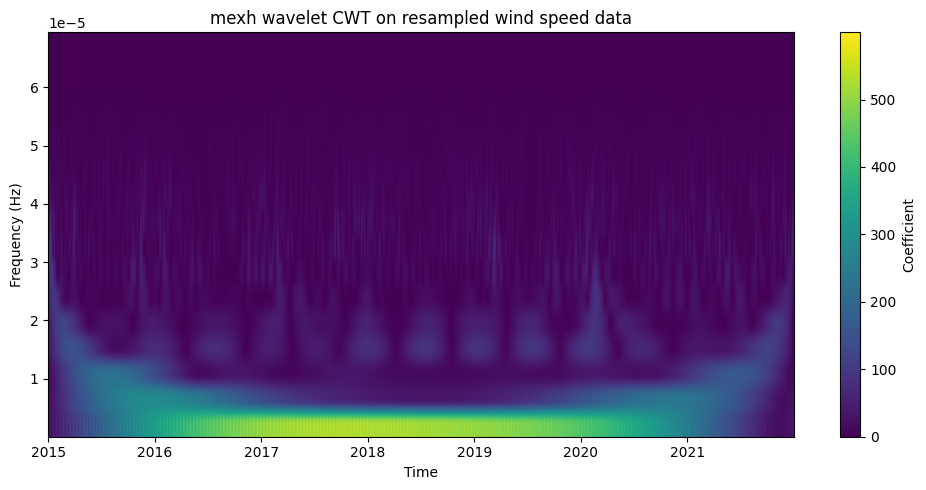

In [9]:
# Wind speed CWT analysis
import pywt

feat = 'Wind Speed (avg)'

min_scale = 1
max_scale = pd.Timedelta(2*365,'days')//resample_rate  # Maximum scale for the wavelet function extension
n_coefs = 16
scales = np.geomspace(min_scale, max_scale, n_coefs)
wavelet = 'mexh'
wind_coef, wind_freqs = pywt.cwt(resampled_feats[feat], scales, wavelet=wavelet)
freq_scaling = pd.Timedelta(1,'second')/resample_rate
wind_freqs = wind_freqs*freq_scaling

plt.figure(figsize=(10, 5))
plt.imshow(np.abs(wind_coef), aspect='auto', cmap='viridis', extent=[resampled_datetimes.iloc[0], resampled_datetimes.iloc[-1], np.min(wind_freqs), np.max(wind_freqs)])
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title(f"{wavelet} wavelet CWT on resampled wind speed data")
cbar = plt.colorbar()
cbar.set_label('Coefficient')
plt.tight_layout()
plt.show()
logging.info(f"CWT performed in wind speed timeseries - {get_td()}")

Test data reconstruction RMSE: 0.88


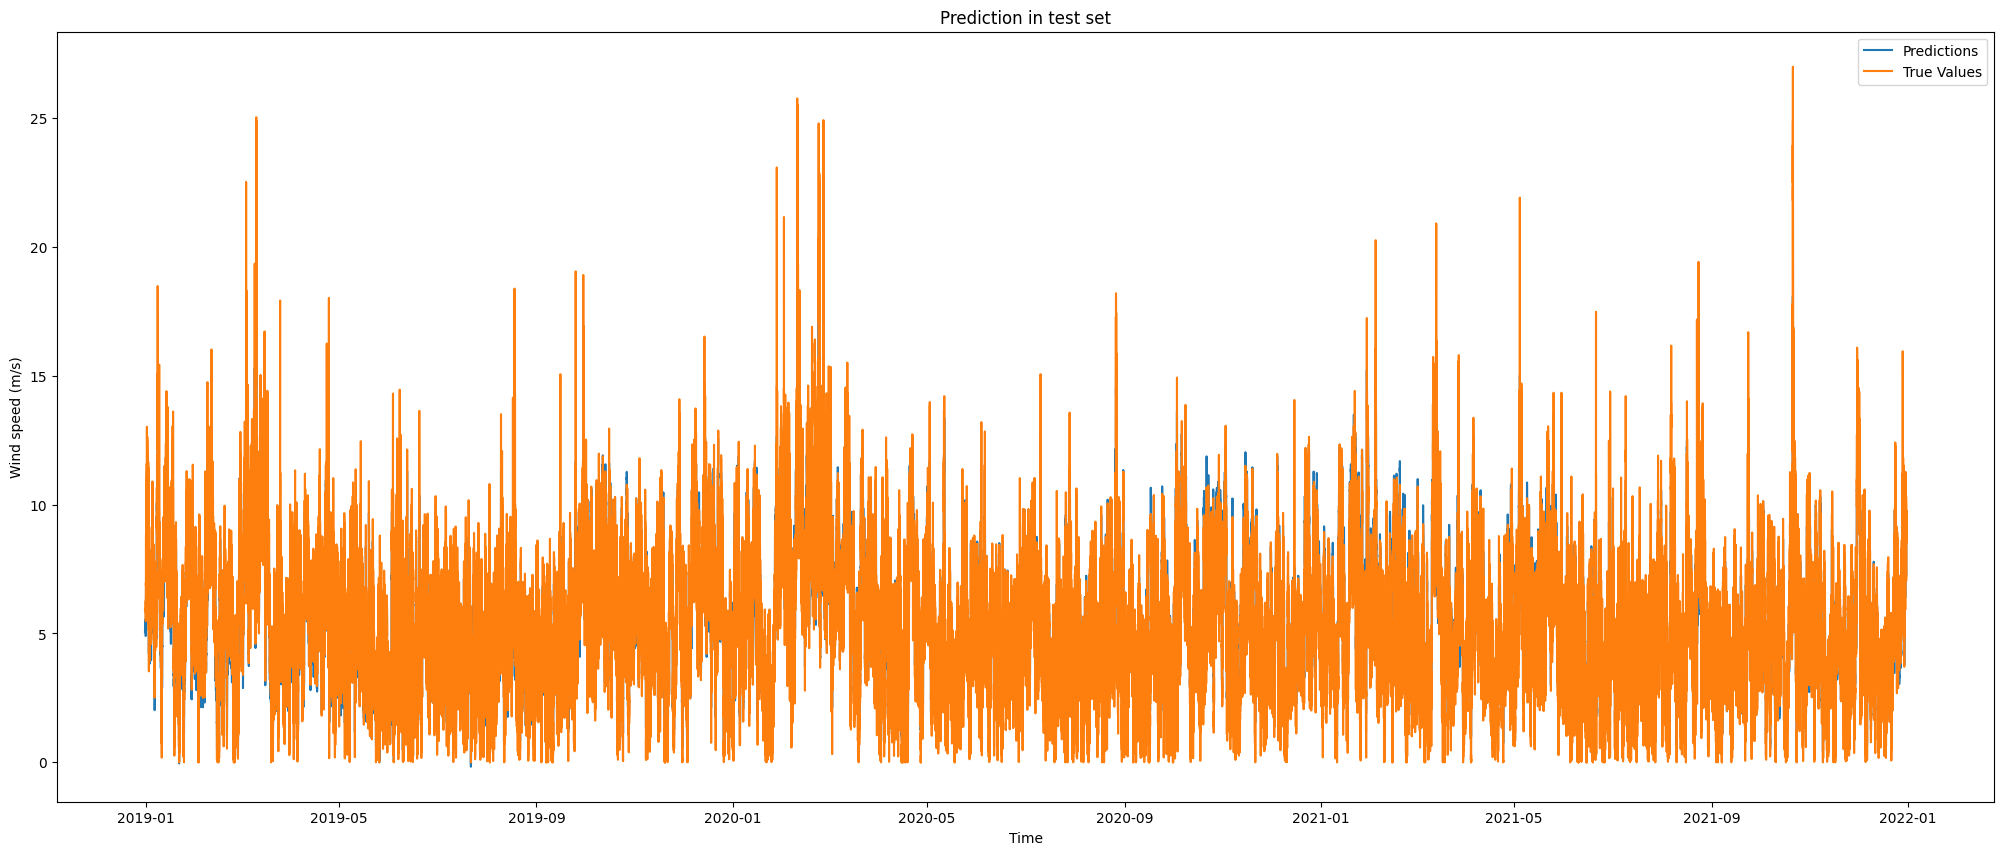

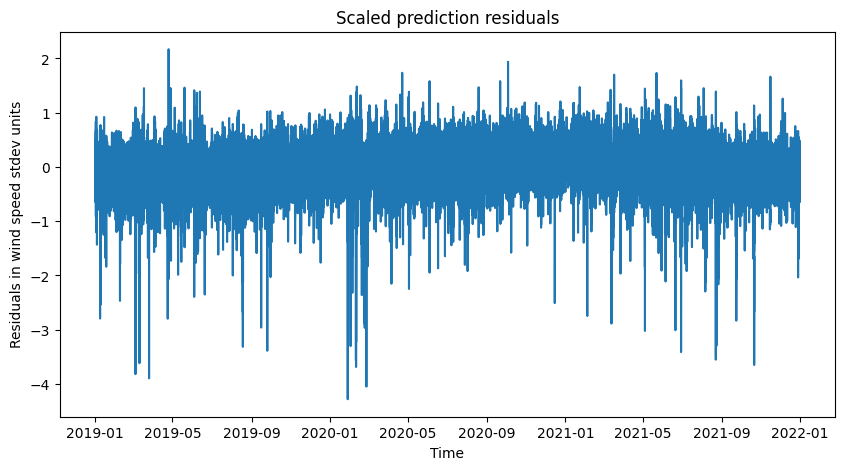

In [10]:
# Wind speed impute
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

corr_feats = get_cor_feats(feat, corr_mat, .8)
wind_features = np.concatenate([wind_coef.T, resampled_feats[corr_feats].values], axis=1)

train_fraction =  4/7
train_features, test_features, train_data, test_data = train_test_split(
    wind_features,
    np.array(hour_groups[feat].apply(list).tolist()),
    train_size=train_fraction,
    shuffle=False
    )

dtrain = xgb.DMatrix(train_features, label=train_data)
dtest = xgb.DMatrix(test_features, label=test_data)
params = {
    'booster': 'gblinear',
    'objective': 'reg:squarederror',
    'gpu_id': 0,
    'learning_rate': 0.12,
    'seed': random_state,
}
model = xgb.train(params, dtrain)

predictions = model.predict(dtest).flatten()

print("Test data reconstruction RMSE: {:.2f}".format(mean_squared_error(test_data.flatten(), predictions, squared=False)))
residuals = predictions-test_data.flatten()

plt.figure(figsize=(25, 10))
plt.plot(full_series.iloc[-len(predictions):].datetime, predictions, label=f'Predictions')
plt.plot(full_series.iloc[-len(predictions):].datetime, test_data.flatten(), label='True Values')
plt.xlabel('Time')
plt.ylabel('Wind speed (m/s)')
plt.legend()
plt.title('Prediction in test set')
plt.show()

plt.figure(figsize=(10, 5))
scaled_residuals = residuals/np.std(test_data.flatten())
plt.plot(full_series.iloc[-len(predictions):].datetime, scaled_residuals)
plt.xlabel('Time')
plt.ylabel('Residuals in wind speed stdev units')
plt.title('Scaled prediction residuals')
plt.show()

# Impute
full_series['group_n'] = pd.Series(full_series.index).apply(lambda x: int(x//(resample_rate/sample_freq)))
full_series['group_ix'] = pd.Series(full_series.index).apply(lambda x: int(x%(resample_rate/sample_freq)))
missing_groups = sorted(list(set(full_series.loc[full_series.is_missing, 'group_n'].values)))
dimpute = xgb.DMatrix(wind_features[missing_groups])
fill_vals = dict(zip(missing_groups, model.predict(dimpute)))
full_series.loc[full_series.is_missing, feat] = [fill_vals.get(group)[i] for group, i in full_series.loc[full_series.is_missing, ['group_n', 'group_ix']].apply(lambda x: tuple(x), axis=1)]
logging.info(f"Wind speed series imputed - {get_td()}")

wind_df = full_series[['datetime', feat]].merge(wind_df, how='left', on='datetime', suffixes=('','_y'))
wind_df.drop(columns=[col for col in wind_df.columns if col.endswith('_y')], inplace=True)
wind_df.reset_index(drop=True, inplace=True)

The results of the wind speed imputation seem satisfactory. The model was created using very few features still the RMSE is quite low on the considerably long test set and the dynamics seem well captured. We can also observe that there does not appear to be any significant bias in the residual distribution in the test set.

We will continue with value imputation while steering towards the goal of modelling the power curve of the turbine, for which we will need the Wind Speed and Active Power features. We can check if there is a any negative drift on the power curve, which could indicate a drop in efficiency of the equipment.

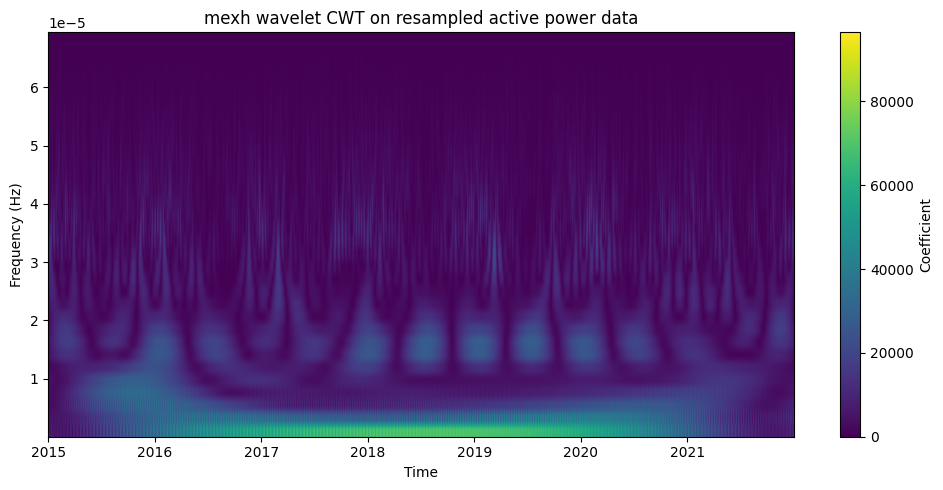

In [11]:
# Active power CWT analysis
import pywt

feat = 'Active Power (avg)'

min_scale = 1
max_scale = pd.Timedelta(2*365,'days')//resample_rate  # Maximum scale for the wavelet function extension
n_coefs = 32
scales = np.geomspace(min_scale, max_scale, n_coefs)
wavelet = 'mexh'
power_coef, power_freqs = pywt.cwt(resampled_feats[feat], scales, wavelet=wavelet)
freq_scaling = pd.Timedelta(1,'second')/resample_rate
power_freqs = power_freqs*freq_scaling

plt.figure(figsize=(10, 5))
plt.imshow(np.abs(power_coef), aspect='auto', cmap='viridis', extent=[resampled_datetimes.iloc[0], resampled_datetimes.iloc[-1], np.min(power_freqs), np.max(power_freqs)])
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title(f"{wavelet} wavelet CWT on resampled active power data")
cbar = plt.colorbar()
cbar.set_label('Coefficient')
plt.tight_layout()
plt.show()
logging.info(f"CWT performed in active power timeseries - {get_td()}")

The CWT suggests that there does not seem to be different dynamic patterns developing overtime. Now we can build an imputation model for active power based on the CWT coefficients and other correlated features.

Test data reconstruction RMSE: 196.44


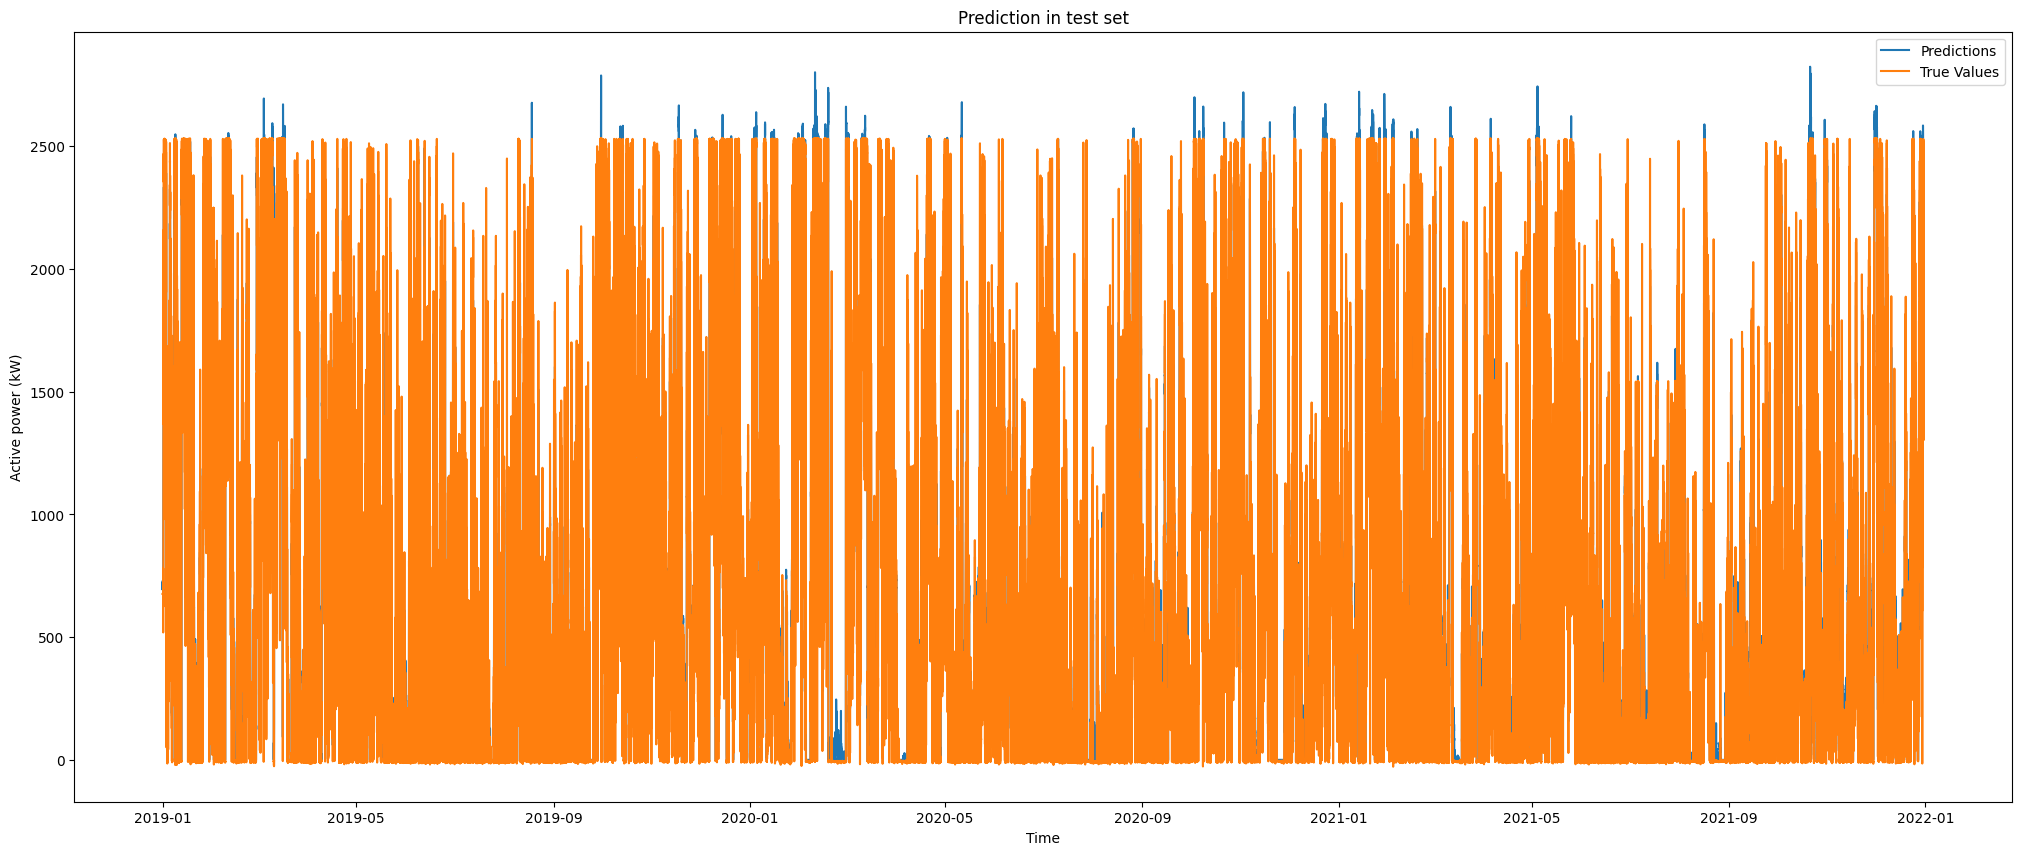

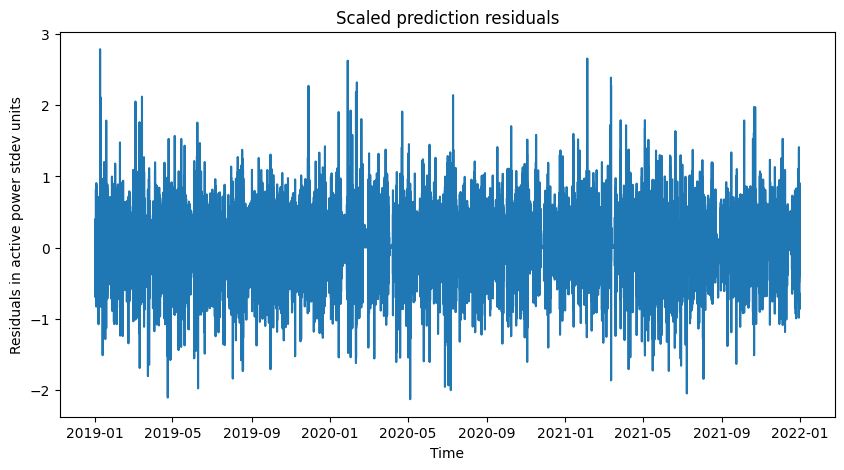

In [12]:
# Active power impute
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

corr_feats = get_cor_feats(feat, corr_mat, .8)
power_features = np.concatenate([power_coef.T, resampled_feats[corr_feats].values], axis=1)

train_fraction =  4/7
train_features, test_features, train_data, test_data = train_test_split(
    power_features,
    np.array(hour_groups[feat].apply(list).tolist()),
    train_size=train_fraction,
    shuffle=False
    )

dtrain = xgb.DMatrix(train_features, label=train_data)
dtest = xgb.DMatrix(test_features, label=test_data)
params = {
    'booster': 'gblinear',
    'objective': 'reg:squarederror',
    'base_score': train_data.min(),
    'gpu_id': 0,
    'learning_rate': 0.12,
    'seed': random_state,
}
model = xgb.train(params, dtrain)

post_proc = lambda x: np.clip(x, 0, np.inf)
predictions = post_proc(model.predict(dtest).flatten())

print("Test data reconstruction RMSE: {:.2f}".format(mean_squared_error(test_data.flatten(), predictions, squared=False)))
residuals = predictions-test_data.flatten()

plt.figure(figsize=(25, 10))
plt.plot(full_series.iloc[-len(predictions):].datetime, predictions, label=f'Predictions')
plt.plot(full_series.iloc[-len(predictions):].datetime, test_data.flatten(), label='True Values')
plt.xlabel('Time')
plt.ylabel('Active power (kW)')
plt.legend()
plt.title('Prediction in test set')
plt.show()

plt.figure(figsize=(10, 5))
scaled_residuals = residuals/np.std(test_data.flatten())
plt.plot(full_series.iloc[-len(predictions):].datetime, scaled_residuals)
plt.xlabel('Time')
plt.ylabel('Residuals in active power stdev units')
plt.title('Scaled prediction residuals')
plt.show()

# Impute
full_series['group_n'] = pd.Series(full_series.index).apply(lambda x: int(x//(resample_rate/sample_freq)))
full_series['group_ix'] = pd.Series(full_series.index).apply(lambda x: int(x%(resample_rate/sample_freq)))
missing_groups = sorted(list(set(full_series.loc[full_series.is_missing, 'group_n'].values)))
dimpute = xgb.DMatrix(power_features[missing_groups])
fill_vals = dict(zip(missing_groups, post_proc(model.predict(dimpute))))
full_series.loc[full_series.is_missing, feat] = [fill_vals.get(group)[i] for group, i in full_series.loc[full_series.is_missing, ['group_n', 'group_ix']].apply(lambda x: tuple(x), axis=1)]
logging.info(f"Active power series imputed - {get_td()}")

wind_df = full_series[['datetime', feat]].merge(wind_df, how='left', on='datetime', suffixes=('','_y'))
wind_df.drop(columns=[col for col in wind_df.columns if col.endswith('_y')], inplace=True)
wind_df.reset_index(drop=True, inplace=True)

c:\Users\isoy\.conda\envs\pred_maint_test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


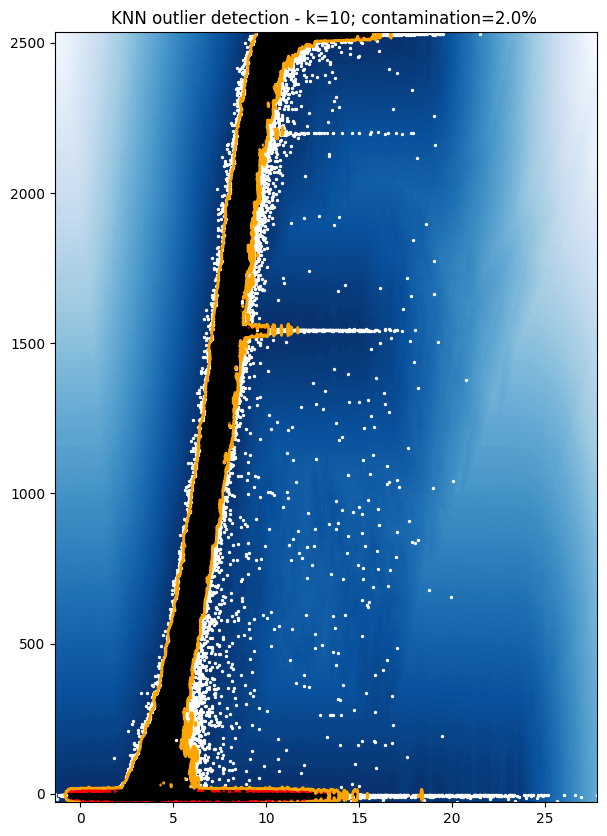

In [13]:
# Outlier detection
import numpy as np
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def get_pipe_components(use_scaler:bool=True, use_pca:bool=True):
    pipe = []

    identity = ("passthrough", lambda x: x)  # Make the pipeline logic reusable even if no scale or pca is used
    scaler = ("scaler", StandardScaler())
    pca = ("pca", PCA(n_components=2))

    if use_scaler:
        pipe.append(scaler)
    if use_pca:
        pipe.append(pca)
    if not pipe:
        pipe.append(identity)
    return pipe

# Configure the pipeline
use_scaler = True
use_pca = False

pipeline = Pipeline(get_pipe_components(use_scaler, use_pca))

od_df = wind_df.loc[:, ['Wind Speed (avg)', 'Active Power (avg)']].copy(deep=True)
od_df[od_df.columns] = pipeline.fit_transform(od_df)

mesh_points = 2000
mesh_x , mesh_y = np.meshgrid(
    np.linspace(wind_df['Wind Speed (avg)'].min(), wind_df['Wind Speed (avg)'].max(), mesh_points),
    np.linspace(wind_df['Active Power (avg)'].min(), wind_df['Active Power (avg)'].max(), mesh_points)
    )
scaled_mesh = pipeline.transform(np.c_[mesh_x.ravel(), mesh_y.ravel()])

x_train, x_test = train_test_split(od_df, test_size=2/3, random_state=random_state)
_x_test = pd.DataFrame.copy(x_test, deep=True)
_x_test[_x_test.columns] = pipeline.inverse_transform(x_test)

contamination = .02

fig, ax = plt.subplots(nrows=1,figsize=(7,10))

model_name = 'KNN'
N=10
model = KNN(n_neighbors=N, contamination=contamination, n_jobs=-1)
model.fit(x_train)

prediction = model.predict(x_test.values)
scores = model.decision_function(x_test.values)

mesh_scores = model.decision_function(scaled_mesh)
mesh_scores = mesh_scores.reshape(mesh_x.shape)

# Plot the results
ax.contourf(mesh_x, mesh_y, mesh_scores, levels=[mesh_scores.min(), model.threshold_], colors='red')
ax.contourf(mesh_x, mesh_y, mesh_scores, levels=np.linspace(model.threshold_, mesh_scores.max(), 100), cmap=plt.cm.Blues_r)
dec_function = ax.contour(mesh_x, mesh_y, mesh_scores, levels=[model.threshold_], linewidths=2, colors='orange')

ax.scatter(
    _x_test.loc[prediction==0, 'Wind Speed (avg)'],
    _x_test.loc[prediction==0, 'Active Power (avg)'],
    c="black",
    label='Inliers',
    s=2
    )
ax.scatter(
    _x_test.loc[prediction==1, 'Wind Speed (avg)'],
    _x_test.loc[prediction==1, 'Active Power (avg)'],
    c="white",
    label='Outliers',
    s=2
    )

ax.set_title('KNN outlier detection - k={}; contamination={:.1%} '.format(N, contamination))
plt.show()

The cut-in speed seems to be at about 6.5 m/s and we can see that KNN OD detection is struggling to flag 0 power output at above cut-in speeds as outliers. Although in real scenarios these observations occur, in programmed downtimes per example, for the purposes of building a power curve we will filter these datapoints again and rebuild the model to remove other outliers.

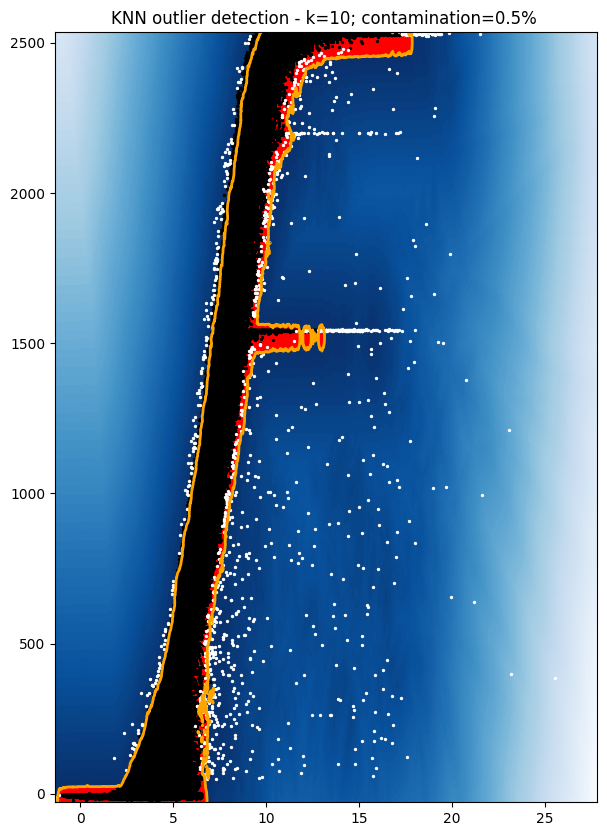

In [14]:
# Outlier detection

od_df = wind_df.loc[:, ['Wind Speed (avg)', 'Active Power (avg)']].copy(deep=True)
od_df = od_df[~((od_df['Wind Speed (avg)']>6.5) & (od_df['Active Power (avg)']<50))]
od_df[od_df.columns] = pipeline.fit_transform(od_df)

x_train, x_test = train_test_split(od_df, test_size=2/3, random_state=random_state)
_x_test = pd.DataFrame.copy(x_test, deep=True)
_x_test[_x_test.columns] = pipeline.inverse_transform(x_test)

contamination = .005

fig, ax = plt.subplots(nrows=1,figsize=(7,10))

model = KNN(n_neighbors=N, contamination=contamination, n_jobs=-1)
model.fit(x_train)

prediction = model.predict(x_test.values)
scores = model.decision_function(x_test.values)

mesh_scores = model.decision_function(scaled_mesh)
mesh_scores = mesh_scores.reshape(mesh_x.shape)

# Plot the results
ax.contourf(mesh_x, mesh_y, mesh_scores, levels=[mesh_scores.min(), model.threshold_], colors='red')
ax.contourf(mesh_x, mesh_y, mesh_scores, levels=np.linspace(model.threshold_, mesh_scores.max(), 100), cmap=plt.cm.Blues_r)
dec_function = ax.contour(mesh_x, mesh_y, mesh_scores, levels=[model.threshold_], linewidths=2, colors='orange')

ax.scatter(
    _x_test.loc[prediction==0, 'Wind Speed (avg)'],
    _x_test.loc[prediction==0, 'Active Power (avg)'],
    c="black",
    label='Inliers',
    s=2
    )
ax.scatter(
    _x_test.loc[prediction==1, 'Wind Speed (avg)'],
    _x_test.loc[prediction==1, 'Active Power (avg)'],
    c="white",
    label='Outliers',
    s=2
    )

ax.set_title('KNN outlier detection - k={}; contamination={:.1%} '.format(N, contamination))
plt.show()

# od_df['prediction'] = model.predict(od_df.loc[:, ['Wind Speed (avg)', target]])

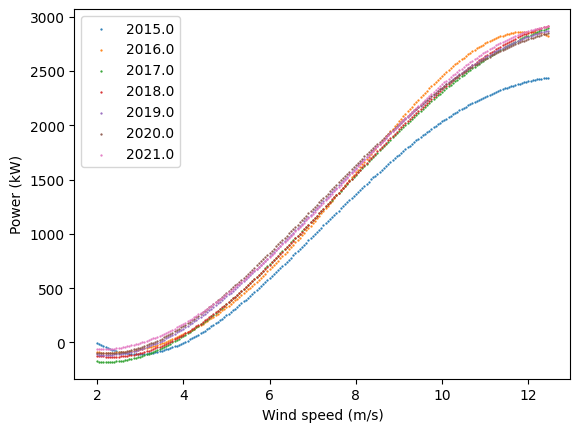

In [15]:
from sklearn.model_selection import KFold

wind_df['inlier'] = True
wind_df.loc[(wind_df['Wind Speed (avg)']>6.5) & (wind_df['Active Power (avg)']<50), 'inlier'] = False
wind_df.loc[wind_df['inlier']==True, 'inlier'] = model.predict(wind_df.loc[wind_df['inlier']==True, ['Wind Speed (avg)', 'Active Power (avg)']]).astype(bool)
wind_df.inlier.value_counts()

year_power_curves = {}
pol_degree = 4
cv_folds = 10
kf_cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
for year, group in wind_df.groupby(wind_df.loc[wind_df['inlier']==True, 'datetime'].apply(lambda x: int(x.year))):
    wind_speed = group['Wind Speed (avg)'].values
    power = group['Active Power (avg)'].values

    power_model = np.zeros((cv_folds, pol_degree+1))

    for i, (train_ixs, test_ixs) in enumerate(kf_cv.split(wind_speed, power)):
        x_train, x_test = wind_speed[train_ixs], wind_speed[test_ixs]
        y_train, y_test = power[train_ixs], power[test_ixs]
        
        params = np.polyfit(x_train, y_train, pol_degree)
        power_model[i] = params

    year_power_curves[year] = np.poly1d(np.mean(power_model,axis=0))

wind_speeds = np.arange(2,12.5,.05)
for year, power_model in year_power_curves.items():
    predictions = power_model(wind_speeds)
    plt.scatter(wind_speeds, predictions, marker='.', s=1.5, label=year)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

The conclusion is surprising, while the immediate expectation was that over the years the wearing of the equipment should drift negatively the power curve, we observe the opposite. The first year had the lowest power rating and later years had better performance and similar between themselves.

Possibly during the first year the turbine was either not optimized or being throttled on purpose during a test period.